## CREATION OF HULLS

#### ALL TEMP HULLS

In [ ]:
### SINGLE RUN OF THE TEMPLATE GENERATION

import template_csp.managetemp as mt
import json
import numpy as np
test_elements = ['Be', 'B', 'N', 'Mg', 'O', 'Li', 'C', 'Na', 'Si', 'S', 'Cl', 'F', 'P', 'H', 'Al']

hyperparameters = { 
    "weight_occurrence" : 1,
    "weight_sg" : 0.001,
    "weight_formation_entalphy" : 1, 

    "comp" : 1,

    "n_final_templates" : 1
}

hull_dict = {}
hull_dict_gs = {}


complist = [1,2,3,4,6]


with open('ENTHALPY/OneEl.json') as f:
    one_el = json.load(f)


for comp in complist:
    hull_dict[comp] = {}
    for i in test_elements:
        for j in test_elements:
            if i == j:
                continue
            hull_dict[comp][i + j] = [0 for x in range(0, 20)]

for comp in complist:

    with open(f'ENTHALPY/A{comp}B.json') as f:
        data = json.load(f)

    for set_id in range(0,20):

        hyperparameters['comp'] = comp

        temp_to_use = [key for key in data['BC'].keys()]

        if comp == 1:
            for i in range(len(test_elements)):
                for j in range(i+1, len(test_elements)):
                    pair_as_list = [test_elements[i], test_elements[j]]
                    pair_as_list.sort()
                    A = pair_as_list[0]
                    B = pair_as_list[1]
                    pair = A + B
                    entA = one_el[A]
                    entB = one_el[B]
                    ent_values = [data[pair][temp] for temp in data[pair].keys() if temp in temp_to_use]
                    ent_min = min(ent_values) - (entA*comp + entB)/(comp+1)

                    hull_dict[comp][pair][set_id] = ent_min
        else:
            for A in test_elements:
                for B in test_elements:
                    if A == B:
                        continue
                    pair = A + B

                    entA = one_el[A]
                    entB = one_el[B]
                    ent_values = [data[pair][temp] for temp in data[pair].keys() if temp in temp_to_use]
                    ent_min = min(ent_values) - (entA*comp + entB)/(comp+1)

                    hull_dict[comp][pair][set_id] = ent_min

        with open('DATA_DICT/PhaseDiagramTempAll.json', 'w') as f:
            json.dump(hull_dict, f, indent=4)
    

### REARRANGE THE DATA FOR THE HULLS

temp_hulls = {}
temp_hulls_std = {}

with open('DATA_DICT/PhaseDiagramTempAll.json') as f:
    old_temp = json.load(f)

complist = [1,2,3,4,6]

for i in range(len(test_elements)):
    for j in range(i+1, len(test_elements)):
        pair_as_list = [test_elements[i], test_elements[j]]
        pair_as_list.sort()
        A = pair_as_list[0]
        B = pair_as_list[1]
        means = []
        stds = []

        for comp in complist:
            entcomp, entcompstd = np.array(old_temp[f'{comp}'][A+B]).mean(), np.array(old_temp[f'{comp}'][A+B]).std()
            means.insert(0, entcomp)
            stds.insert(0, entcompstd)

            if comp != 1:
                entcomp, entcompstd = np.array(old_temp[f'{comp}'][B+A]).mean(), np.array(old_temp[f'{comp}'][B+A]).std()
                means.append(entcomp)
                stds.append(entcompstd)
        
        temp_hulls[A+B] = means
        temp_hulls_std[A+B] = stds


with open('DATA_DICT/PhaseDiagramTempAll.json', 'w') as f:
    json.dump(temp_hulls, f, indent=4)


 

#### GS HULLS

In [ ]:
# GS HULLS

import json 

hull_gs = {}

with open('ENTHALPY/EntGS.json') as f:
    ent_gs_dict = json.load(f)
with open('ENTHALPY/OneEl.json') as f:
    one_el = json.load(f)

test_elements = ['Be', 'B', 'N', 'Mg', 'O', 'Li', 'C', 'Na', 'Si', 'S', 'Cl', 'F', 'P', 'H', 'Al']

complist = [1,2,3,4,6]

for comp in complist:
    hull_gs[comp] = {}
    if comp == 1:
        for i in range(len(test_elements)):
            for j in range(i+1, len(test_elements)):
                pair_as_list = [test_elements[i], test_elements[j]]
                pair_as_list.sort()
                A = pair_as_list[0]
                B = pair_as_list[1]
                pair = A + B
                entA = one_el[A]
                entB = one_el[B]

                ent_gs = ent_gs_dict[f'{comp}'][pair] - (entA*comp + entB)/(comp+1)

                hull_gs[comp][pair] = ent_gs
    else:
        for A in test_elements:
            for B in test_elements:
                if A == B:
                    continue
                pair = A + B

                entA = one_el[A]
                entB = one_el[B]
                ent_gs = ent_gs_dict[f'{comp}'][pair] - (entA*comp + entB)/(comp+1)

                hull_gs[comp][pair] = ent_gs

    with open('PhaseDiagramUspex.json', 'w') as f:
        json.dump(hull_gs, f, indent=4)

### REARRANGE THE DATA
gs_hulls = {}


with open('PhaseDiagramUspex.json') as f:
    old_gs = json.load(f)

complist = [1,2,3,4,6]

for i in range(len(test_elements)):
    for j in range(i+1, len(test_elements)):
        pair_as_list = [test_elements[i], test_elements[j]]
        pair_as_list.sort()
        A = pair_as_list[0]
        B = pair_as_list[1]
        gs = []

        for comp in complist:

            ent_gs = old_gs[f'{comp}'][A+B]
            gs.insert(0, ent_gs)
            if comp != 1:

                ent_gs = old_gs[f'{comp}'][B+A]
                gs.append(ent_gs)

        gs_hulls[A+B] = gs

with open('PhaseDiagramUspex.json', 'w') as f:
    json.dump(gs_hulls, f, indent=4)




#### TEMP HULLS

In [11]:
### SINGLE RUN OF THE TEMPLATE GENERATION

import template_csp.managetemp as mt
import json
import numpy as np
test_elements = ['Be', 'B', 'N', 'Mg', 'O', 'Li', 'C', 'Na', 'Si', 'S', 'Cl', 'F', 'P', 'H', 'Al']

hyperparameters = { 
    "weight_occurrence" : 1,
    "weight_sg" : 0.001,
    "weight_formation_entalphy" : 1, 

    "comp" : 1,

    "n_final_templates" : 1,
    "job_id" : 1,
    "n_template" : 1 
}

hull_dict = {}
hull_dict_gs = {}


complist = [1,2,3,4,6]
final_size = [10,20,15,15,10]
initial_size = [20,45,30,30,20]

with open('ENTHALPY/EntGS.json') as f:
    ent_gs_dict = json.load(f)
with open('ENTHALPY/OneEl.json') as f:
    one_el = json.load(f)

for comp in complist:
    hull_dict[comp] = {}
#     for i in test_elements:
#         for j in test_elements:
#             if i == j:
#                 continue
#             hull_dict[comp][i + j] = [0 for x in range(0, 20)]

for comp in complist:

    hyperparameters['comp'] = comp
    hyperparameters['n_final_templates'] = final_size[complist.index(comp)]
    hyperparameters['n_pairs'] = 105 if comp == 1 else 210
    hyperparameters['n_template'] = initial_size[complist.index(comp)]
    hyperparameters['n_final_templates'] = final_size[complist.index(comp)]

    with open(f'ENTHALPY/A{comp}B.json') as f:
        data = json.load(f)

    for set_id in range(0,20):

        temp_init = mt.generate_initial_set(test_elements=test_elements, hyperparameters=hyperparameters)
        
        temp_final = mt.generate_final_set(temp_init, hyperparameters, test_elements)
    
        temp_to_use = temp_final.reduced_set()

        if comp == 1:
            for i in range(len(test_elements)):
                for j in range(i+1, len(test_elements)):
                    pair_as_list = [test_elements[i], test_elements[j]]
                    pair_as_list.sort()
                    A = pair_as_list[0]
                    B = pair_as_list[1]
                    pair = A + B
                    entA = one_el[A]
                    entB = one_el[B]
                    ent_values = [data[pair][temp] for temp in data[pair].keys() if temp in temp_to_use]
                    ent_min = min(ent_values) - (entA*comp + entB)/(comp+1)
                    
                    if pair not in hull_dict[comp]:
                        hull_dict[comp][pair] = []
                    hull_dict[comp][pair].append(ent_min)
        
        else:
            for A in test_elements:
                for B in test_elements:
                    if A == B:
                        continue
                    pair = A + B

                    entA = one_el[A]
                    entB = one_el[B]
                    ent_values = [data[pair][temp] for temp in data[pair].keys() if temp in temp_to_use]
                    ent_min = min(ent_values) - (entA*comp + entB)/(comp+1)

                    if pair not in hull_dict[comp]:
                        hull_dict[comp][pair] = []
                    hull_dict[comp][pair].append(ent_min)

        with open('PhaseDiagramTemp1.json', 'w') as f:
            json.dump(hull_dict, f, indent=4)
    

### REARRANGE THE DATA FOR THE HULLS

temp_hulls = {}
temp_hulls_std = {}

with open('PhaseDiagramTemp1.json') as f:
    old_temp = json.load(f)

complist = [1,2,3,4,6]

for i in range(len(test_elements)):
    for j in range(i+1, len(test_elements)):
        pair_as_list = [test_elements[i], test_elements[j]]
        pair_as_list.sort()
        A = pair_as_list[0]
        B = pair_as_list[1]
        means = []
        stds = []

        for comp in complist:
            entcomp, entcompstd = np.array(old_temp[f'{comp}'][A+B]).mean(), np.array(old_temp[f'{comp}'][A+B]).std()
            means.insert(0, entcomp)
            stds.insert(0, entcompstd)

            if comp != 1:
                entcomp, entcompstd = np.array(old_temp[f'{comp}'][B+A]).mean(), np.array(old_temp[f'{comp}'][B+A]).std()
                means.append(entcomp)
                stds.append(entcompstd)
        
        temp_hulls[A+B] = means
        temp_hulls_std[A+B] = stds


with open('PhaseDiagramTemp.json', 'w') as f:
    json.dump(temp_hulls, f, indent=4)

with open('PhaseDiagramTempStd.json', 'w') as f:
    json.dump(temp_hulls_std, f, indent=4)


 

#### STD HULLS PROF

In [4]:
import json
import numpy as np
import os
import template_csp.managetemp as mt

complist = [1,2,3,4,6]
final_size = [10,20,15,15,10]
initial_size = [20,45,30,30,20]

test_elements = ['Be', 'B', 'N', 'Mg', 'O', 'Li', 'C', 'Na', 'Si', 'S', 'Cl', 'F', 'P', 'H', 'Al']

hyperparameters = { 
    "weight_occurrence" : 1,
    "weight_sg" : 0.001,
    "weight_formation_entalphy" : 1, 

    "comp" : 1,

    "n_final_templates" : 1
}
std_prof = [0 for x in range(len(complist))]


for idx_comp, comp in enumerate(complist):
    hyperparameters['comp'] = comp
    hyperparameters['n_pairs'] = 105 if comp == 1 else 210
    init, final = initial_size[complist.index(comp)], final_size[complist.index(comp)]
    for set_id in range(0,20):
        temp_init = mt.InitialSet(test_elements=test_elements, hyperparameters=hyperparameters, restart_file=f'HvsINIT/{comp}/{init}/InitialSet_{set_id}')
        hyperparameters['n_final_templates'] = final
        temp_final = mt.generate_final_set(init_set=temp_init, test_elements=test_elements, hyperparameters=hyperparameters)
        std_prof[idx_comp] += temp_final.difference_from_uspex()/20

std2 = std_prof[1:]
temp_hulls_std_prof = std_prof[::-1] + std2 

with open('MethodAccuracySTD.txt' , 'w') as f:
    f.write('[')
    for i in temp_hulls_std_prof[:-1]:
        f.write(f'{i},')
    f.write(f'{temp_hulls_std_prof[-1]}]')

## AREA DIFFERENCE

In [5]:
from scipy.spatial import ConvexHull
import numpy as np
from scipy.interpolate import interp1d
import json
import matplotlib.pyplot as plt
from scipy.integrate import simpson

x = [0,1/7,1/5,1/4,1/3,1/2,2/3,3/4,4/5,6/7,1]


dir_dati = './DATA_DICT/'

with open(dir_dati + 'PhaseDiagramUspex.json', 'r') as f:
    gs_hulls = json.load(f)

with open(dir_dati + 'PhaseDiagramTemp.json', 'r') as f:
    temp_hulls = json.load(f)

with open(dir_dati + 'PhaseDiagramTempStd.json', 'r') as f:
    temp_hulls_std = json.load(f)

areas = {}

lista_pair = list(temp_hulls.keys())

for idx_pair in range(len(lista_pair)):
    y_uspex = [j for j in gs_hulls[lista_pair[idx_pair]]]
    y_uspex.insert(0,0)
    y_uspex.append(0)
    y_temp = [j for j in temp_hulls[lista_pair[idx_pair]]]
    y_temp.insert(0,0)
    y_temp.append(0)


    points_uspex = np.column_stack((x, y_uspex))
    points_temp = np.column_stack((x, y_temp))
    # Calcoliamo la convex hull
    hull_uspex = ConvexHull(points_uspex)
    hull_temp = ConvexHull(points_temp)

    ### Uspex x and y of the hull
    x_uspex = []
    y_uspex = []
    for simplex in hull_uspex.simplices:
        x1, y1 = points_uspex[simplex[0]]
        x2, y2 = points_uspex[simplex[1]]
        if y1 == 0 and y2 == 0:
            continue
        if y1 <= 0 and y2 <= 0:
            if x1 not in x_uspex:
                x_uspex.append(x1)
                y_uspex.append(y1)
            if x2 not in x_uspex:
                x_uspex.append(x2)
                y_uspex.append(y2)
    if len(x_uspex) == 0:
        x_uspex.append(0)
        y_uspex.append(0)
        x_uspex.append(1)
        y_uspex.append(0)

    ### TEMP x and y of the hull
    x_temp = []
    y_temp = []
    for simplex in hull_temp.simplices:
        x1, y1 = points_temp[simplex[0]]
        x2, y2 = points_temp[simplex[1]]
        if y1 == 0 and y2 == 0:
            continue
        if y1 <= 0 and y2 <= 0:
            if x1 not in x_temp:
                x_temp.append(x1)
                y_temp.append(y1)
            if x2 not in x_temp:
                x_temp.append(x2)
                y_temp.append(y2)
    if len(x_temp) == 0:
        x_temp.append(0)
        y_temp.append(0)
        x_temp.append(1)
        y_temp.append(0)

    ## AREA between the two hulls
    

    interpol_uspex = interp1d(x_uspex, y_uspex, kind='linear', fill_value='extrapolate')
    interpol_temp = interp1d(x_temp, y_temp, kind='linear', fill_value='extrapolate')
    
    usp_inter = np.array(interpol_uspex(x))
    temp_inter = np.array(interpol_temp(x))

    diff = np.abs(usp_inter - temp_inter)

    area = simpson(diff, x)

    areas[lista_pair[idx_pair]] = area

with open('DATA_DICT/Areas_hulls.json', 'w') as f:
    json.dump(areas, f, indent=4)

## HULL STATS

### OLD DICT

In [ ]:
from scipy.spatial import ConvexHull
import numpy as np
from scipy.interpolate import interp1d
import json


x = [0,1/7,1/5,1/4,1/3,1/2,2/3,3/4,4/5,6/7,1]


dir_dati = './DATA_DICT/'

with open(dir_dati + 'PhaseDiagramUspex.json', 'r') as f:
    gs_hulls = json.load(f)

with open(dir_dati + 'PhaseDiagramTemp.json', 'r') as f:
    temp_hulls = json.load(f)

with open(dir_dati + 'PhaseDiagramTempStd.json', 'r') as f:
    temp_hulls_std = json.load(f)

with open(dir_dati + 'Areas_hulls.json', 'r') as f:
    areas = json.load(f)

vector_temp_dict = {}

prof = True

no_std = True

if prof:
    with open(dir_dati + 'MethodAccuracySTD.txt', 'r') as f:
        text = f.readlines()
    temp_hulls_std_prof = eval(text[0])

lista_pair = list(temp_hulls.keys())

for idx_pair in range(len(lista_pair)):
    y_uspex = [j for j in gs_hulls[lista_pair[idx_pair]]]
    y_uspex.insert(0,0)
    y_uspex.append(0)
    y_temp = [j for j in temp_hulls[lista_pair[idx_pair]]]
    y_temp.insert(0,0)
    y_temp.append(0)

    lowest_point = min(y_temp)

    if no_std:
        y_std_max = y_temp
        y_std_min = y_temp
    
    else:
        if not prof:
            y_std_max = [j+i for j, i in zip(temp_hulls_std[lista_pair[idx_pair]], temp_hulls[lista_pair[idx_pair]])]
            y_std_max.insert(0,0)
            y_std_max.append(0)
            y_std_min = [j-i for j, i in zip(temp_hulls[lista_pair[idx_pair]], temp_hulls_std[lista_pair[idx_pair]])]
            y_std_min.insert(0,0)
            y_std_min.append(0)
        else:
            y_std_max = [j+i for j, i in zip(temp_hulls_std_prof, temp_hulls[lista_pair[idx_pair]])]
            y_std_max.insert(0,0)
            y_std_max.append(0)
            y_std_min = [j-i for j, i in zip(temp_hulls[lista_pair[idx_pair]], temp_hulls_std_prof)]
            y_std_min.insert(0,0)
            y_std_min.append(0)

    points_uspex = np.column_stack((x, y_uspex))
    points_temp_std_max = np.column_stack((x, y_std_max))
    points_temp_std_min = np.column_stack((x, y_std_min))
    points_temp = np.column_stack((x, y_temp))

    # Calcoliamo la convex hull
    hull_uspex = ConvexHull(points_uspex)
    hull_temp = ConvexHull(points_temp)
    hull_temp_std_max = ConvexHull(points_temp_std_max)
    hull_temp_std_min = ConvexHull(points_temp_std_min)

    ### VETTORE HULL DI USPEX
    vector_uspex = [0 for i in x]
    vector_uspex[0] = 1
    vector_uspex[-1] = 1
    for simplex in hull_uspex.simplices:
        x1, y1 = points_uspex[simplex[0]]
        x2, y2 = points_uspex[simplex[1]]
        if y1 == 0 and y2 == 0:  
            continue
        if y1 <= 0 and y2 <= 0:  
            vector_uspex[x.index(x1)] = 1
            vector_uspex[x.index(x2)] = 1


    ### UPPER LIMIT HULL TEMP
    upper_limit_x = []
    upper_limit_y = []

    upper_hull_points = [0 for i in range(len(x))]
    upper_hull_points[0] = 1
    upper_hull_points[-1] = 1

    for simplex in hull_temp_std_max.simplices:
        x1, y1 = points_temp_std_max[simplex[0]]
        x2, y2 = points_temp_std_max[simplex[1]]
        if y1 == 0 and y2 == 0:
            continue
        if y1 <= 0 and y2 <= 0:  
            upper_hull_points[x.index(x1)] = 1
            upper_hull_points[x.index(x2)] = 1
            if x1 not in upper_limit_x:
                upper_limit_x.append(x1)
                upper_limit_y.append(y1)
            if x2 not in upper_limit_x:
                upper_limit_x.append(x2)
                upper_limit_y.append(y2)
    if len(upper_limit_x) == 0:
        upper_limit_x.append(0)
        upper_limit_y.append(0)
        upper_limit_x.append(1)
        upper_limit_y.append(0)
    upper_limit_x = np.array(upper_limit_x)
    upper_limit_y = np.array(upper_limit_y)
    upper_limit_y = upper_limit_y[upper_limit_x.argsort()]
    upper_limit_x = upper_limit_x[upper_limit_x.argsort()]

    ### LOWER LIMIT HULL TEMP
    lower_limit_x = []
    lower_limit_y = []

    lower_hull_points = [0 for i in range(len(x))]
    lower_hull_points[0] = 1
    lower_hull_points[-1] = 1

    for simplex in hull_temp_std_min.simplices:
        x1, y1 = points_temp_std_min[simplex[0]]
        x2, y2 = points_temp_std_min[simplex[1]]
        if y1 == 0 and y2 == 0:
            continue
        if y1 <= 0 and y2 <= 0:  
            lower_hull_points[x.index(x1)] = 1
            lower_hull_points[x.index(x2)] = 1
            
            if x1 not in lower_limit_x:
                lower_limit_x.append(x1)
                lower_limit_y.append(y1)
            if x2 not in lower_limit_x:
                lower_limit_x.append(x2)
                lower_limit_y.append(y2)
    if len(lower_limit_x) == 0:
        lower_limit_x.append(0)
        lower_limit_y.append(0)
        lower_limit_x.append(1)
        lower_limit_y.append(0)
        
    lower_limit_x = np.array(lower_limit_x)
    lower_limit_y = np.array(lower_limit_y)
    lower_limit_y = lower_limit_y[lower_limit_x.argsort()]
    lower_limit_x = lower_limit_x[lower_limit_x.argsort()]

    ### TEMP HULL POINTS

    temp_hull_points = [0 for i in range(len(x))]
    temp_hull_points[0] = 1
    temp_hull_points[-1] = 1

    for simplex in hull_temp.simplices:
        x1, y1 = points_temp[simplex[0]]
        x2, y2 = points_temp[simplex[1]]
        if y1 == 0 and y2 == 0:
            continue
        if y1 <= 0 and y2 <= 0:  
            temp_hull_points[x.index(x1)] = 1
            temp_hull_points[x.index(x2)] = 1


    ### TEMP HULL VECTOR IF BETWEEN UPPER AND LOWER LIMIT    
    vector_temp = [0 for i in x]

    interpol_upper = interp1d(upper_limit_x, upper_limit_y, kind='linear', fill_value='extrapolate')
    interpol_lower = interp1d(lower_limit_x, lower_limit_y, kind='linear', fill_value='extrapolate')

    upper_interpol = interpol_upper(x)
    lower_interpol = interpol_lower(x)


    for i, comp in enumerate(x):
        up = upper_interpol[i]
        low = lower_interpol[i]

        if y_temp[i] <= up and y_temp[i] >= low:
            
            vector_temp[i] = 1
        else:
            vector_temp[i] = 0

    vector_temp = np.array(vector_temp[1:-1])
    vector_uspex = np.array(vector_uspex[1:-1])

    scalar_product = 0
    for l in range(len(vector_temp)):
        if vector_temp[l] == vector_uspex[l]:
            scalar_product += 1

    scalar_product = scalar_product / len(vector_temp)

    vector_temp_dict[lista_pair[idx_pair]] = {
        'scalar_product': float(scalar_product),
        'min': lowest_point,
        'area': areas[lista_pair[idx_pair]],
        'vector_temp': vector_temp.tolist(),
        'vector_uspex': vector_uspex.tolist(),
        'points_temp': temp_hull_points,
        'points_upper': upper_hull_points,
        'points_lower': lower_hull_points,
    }

with open('DATA_DICT/InfoHullTemp.json', 'w') as f:
    json.dump(vector_temp_dict, f, indent=4)

### DICT NEW

In [12]:
from scipy.spatial import ConvexHull
import numpy as np
from scipy.interpolate import interp1d
import json


x = [0,1/7,1/5,1/4,1/3,1/2,2/3,3/4,4/5,6/7,1]


dir_dati = './DATA_DICT/'

with open(dir_dati + 'MinimumEachComp/PhaseDiagramUspex.json', 'r') as f:
    gs_hulls = json.load(f)

with open(dir_dati + 'MinimumEachComp/PhaseDiagramTemp.json', 'r') as f:
    temp_hulls = json.load(f)

with open(dir_dati + 'MinimumEachComp/PhaseDiagramTempStd.json', 'r') as f:
    temp_hulls_std = json.load(f)

with open(dir_dati + 'Areas_hulls.json', 'r') as f:
    areas = json.load(f)

vector_temp_dict = {}
dict_std = {}

prof = True # DECIDE WHICH TIPE OF STD TO USE

on_hull_if_in_std = False # DECIDE IF CONSIDER THE POINTS ON THE HULL IF THEY ARE IN THE STD AREA

if prof:
    with open(dir_dati + 'MethodAccuracySTD.txt', 'r') as f:
        text = f.readlines()
    temp_hulls_std_prof = eval(text[0])

lista_pair = list(temp_hulls.keys())

for idx_pair in range(len(lista_pair)):
    y_uspex = [j for j in gs_hulls[lista_pair[idx_pair]]]
    y_uspex.insert(0,0)
    y_uspex.append(0)
    y_temp = [j for j in temp_hulls[lista_pair[idx_pair]]]
    y_temp.insert(0,0)
    y_temp.append(0)

    lowest_point = min(y_temp)

    points_uspex = np.column_stack((x, y_uspex))
    points_temp = np.column_stack((x, y_temp))
    hull_uspex = ConvexHull(points_uspex)
    hull_temp = ConvexHull(points_temp)

    ### HULL DI USPEX

    # Vettore di 0 and 1 per la composizione
    vector_uspex = [0 for i in x]
    vector_uspex[0] = 1
    vector_uspex[-1] = 1

    # Valori effettivi composizione e entalpia
    ent_uspex_on_hull = []
    comp_uspex_on_hull = []

    for simplex in hull_uspex.simplices:
        x1, y1 = points_uspex[simplex[0]]
        x2, y2 = points_uspex[simplex[1]]
        if y1 == 0 and y2 == 0:
            continue
        if y1 <= 0 and y2 <= 0:  
            vector_uspex[x.index(x1)] = 1
            vector_uspex[x.index(x2)] = 1

            if x1 not in comp_uspex_on_hull:
                comp_uspex_on_hull.append(x1)
                ent_uspex_on_hull.append(y1)
            if x2 not in comp_uspex_on_hull:
                comp_uspex_on_hull.append(x2)
                ent_uspex_on_hull.append(y2)
        
    if len(comp_uspex_on_hull) == 0:
        comp_uspex_on_hull.append(0)
        ent_uspex_on_hull.append(0)
        comp_uspex_on_hull.append(1)
        ent_uspex_on_hull.append(0)

    comp_uspex_on_hull = np.array(comp_uspex_on_hull)
    ent_uspex_on_hull = np.array(ent_uspex_on_hull)
    ent_uspex_on_hull = ent_uspex_on_hull[comp_uspex_on_hull.argsort()]
    comp_uspex_on_hull = comp_uspex_on_hull[comp_uspex_on_hull.argsort()]

    ### TEMP HULL

    # Vettore di 0 and 1 per la composizione
    temp_hull_points = [0 for i in range(len(x))]
    temp_hull_points[0] = 1
    temp_hull_points[-1] = 1

    # Valori effettivi composizione e entalpia
    comp_temp_on_hull = []
    ent_temp_on_hull = []

    for simplex in hull_temp.simplices:
        x1, y1 = points_temp[simplex[0]]
        x2, y2 = points_temp[simplex[1]]
        if y1 == 0 and y2 == 0:
            continue
        if y1 <= 0 and y2 <= 0:  
            temp_hull_points[x.index(x1)] = 1
            temp_hull_points[x.index(x2)] = 1

            if x1 not in comp_temp_on_hull:
                comp_temp_on_hull.append(x1)
                ent_temp_on_hull.append(y1)
            if x2 not in comp_temp_on_hull:
                comp_temp_on_hull.append(x2)
                ent_temp_on_hull.append(y2)
    if len(comp_temp_on_hull) == 0:
        comp_temp_on_hull.append(0)
        ent_temp_on_hull.append(0)
        comp_temp_on_hull.append(1)
        ent_temp_on_hull.append(0)
    comp_temp_on_hull = np.array(comp_temp_on_hull)
    ent_temp_on_hull = np.array(ent_temp_on_hull)
    ent_temp_on_hull = ent_temp_on_hull[comp_temp_on_hull.argsort()]
    comp_temp_on_hull = comp_temp_on_hull[comp_temp_on_hull.argsort()]



    if not prof:
        y_std_max = [j+i for j, i in zip(temp_hulls_std[lista_pair[idx_pair]], temp_hulls[lista_pair[idx_pair]])]
        y_std_max.insert(0,0)
        y_std_max.append(0)
        y_std_min = [j-i for j, i in zip(temp_hulls[lista_pair[idx_pair]], temp_hulls_std[lista_pair[idx_pair]])]
        y_std_min.insert(0,0)
        y_std_min.append(0)
    else:
        y_std_max = [j+i for j, i in zip(temp_hulls_std_prof, temp_hulls[lista_pair[idx_pair]])]
        y_std_max.insert(0,0)
        y_std_max.append(0)
        y_std_min = [j-i for j, i in zip(temp_hulls[lista_pair[idx_pair]], temp_hulls_std_prof)]
        y_std_min.insert(0,0)
        y_std_min.append(0)

    points_temp_std_max = np.column_stack((x, y_std_max))
    points_temp_std_min = np.column_stack((x, y_std_min))
    hull_temp_std_max = ConvexHull(points_temp_std_max)
    hull_temp_std_min = ConvexHull(points_temp_std_min)

    ### UPPER STD HULL TEMP

    # Vettore di 0 and 1 per la composizione
    upper_hull_points = [0 for i in range(len(x))]
    upper_hull_points[0] = 1
    upper_hull_points[-1] = 1

    # Valori effettivi composizione e entalpia
    upper_limit_x = []
    upper_limit_y = []

    for simplex in hull_temp_std_max.simplices:
        x1, y1 = points_temp_std_max[simplex[0]]
        x2, y2 = points_temp_std_max[simplex[1]]
        if y1 == 0 and y2 == 0:
            continue
        if y1 <= 0 and y2 <= 0:  
            upper_hull_points[x.index(x1)] = 1
            upper_hull_points[x.index(x2)] = 1

            if x1 not in upper_limit_x:
                upper_limit_x.append(x1)
                upper_limit_y.append(y1)
            if x2 not in upper_limit_x:
                upper_limit_x.append(x2)
                upper_limit_y.append(y2)
    
    if len(upper_limit_x) == 0:
        upper_limit_x.append(0)
        upper_limit_y.append(0)
        upper_limit_x.append(1)
        upper_limit_y.append(0)

    upper_limit_x = np.array(upper_limit_x)
    upper_limit_y = np.array(upper_limit_y)
    upper_limit_y = upper_limit_y[upper_limit_x.argsort()]
    upper_limit_x = upper_limit_x[upper_limit_x.argsort()]

    ### LOWER STD LIMIT HULL TEMP

    # Vettore di 0 and 1 per la composizione
    lower_hull_points = [0 for i in range(len(x))]
    lower_hull_points[0] = 1
    lower_hull_points[-1] = 1

    # Valori effettivi composizione e entalpia
    lower_limit_x = []
    lower_limit_y = []

    for simplex in hull_temp_std_min.simplices:
        x1, y1 = points_temp_std_min[simplex[0]]
        x2, y2 = points_temp_std_min[simplex[1]]
        if y1 == 0 and y2 == 0:
            continue
        if y1 <= 0 and y2 <= 0:  
            lower_hull_points[x.index(x1)] = 1
            lower_hull_points[x.index(x2)] = 1
            
            if x1 not in lower_limit_x:
                lower_limit_x.append(x1)
                lower_limit_y.append(y1)
            if x2 not in lower_limit_x:
                lower_limit_x.append(x2)
                lower_limit_y.append(y2)

    if len(lower_limit_x) == 0:
        lower_limit_x.append(0)
        lower_limit_y.append(0)
        lower_limit_x.append(1)
        lower_limit_y.append(0)

    lower_limit_x = np.array(lower_limit_x)
    lower_limit_y = np.array(lower_limit_y)
    lower_limit_y = lower_limit_y[lower_limit_x.argsort()]
    lower_limit_x = lower_limit_x[lower_limit_x.argsort()]


    
    vector_temp = [0 for i in x]

    if on_hull_if_in_std: ### TEMP HULL VECTOR IF BETWEEN UPPER AND LOWER LIMIT

        interpol_upper = interp1d(upper_limit_x, upper_limit_y, kind='linear', fill_value='extrapolate')
        interpol_lower = interp1d(lower_limit_x, lower_limit_y, kind='linear', fill_value='extrapolate')

        upper_interpol = interpol_upper(x)
        lower_interpol = interpol_lower(x)

        for i, comp in enumerate(x):
            up = upper_interpol[i]
            low = lower_interpol[i]

            if y_temp[i] <= up and y_temp[i] >= low:
                
                vector_temp[i] = 1
            else:
                vector_temp[i] = 0

    else:               ### TEMP HULL VECTOR IF ON THE HULL

        vector_temp = [i for i in temp_hull_points]

    vector_temp = np.array(vector_temp[1:-1])
    vector_uspex = np.array(vector_uspex[1:-1])

    scalar_product = 0
    for l in range(len(vector_temp)):
        if vector_temp[l] == vector_uspex[l]:
            scalar_product += 1

    scalar_product = scalar_product / len(vector_temp)

    vector_temp_dict[lista_pair[idx_pair]] = {
        'scalar_product': float(scalar_product),
        'min': lowest_point,
        'area': areas[lista_pair[idx_pair]],
        'vector_temp': vector_temp.tolist(),
        'vector_uspex': vector_uspex.tolist(),
        'temp_hulls_y': ent_temp_on_hull.tolist(),
        'temp_hulls_x': comp_temp_on_hull.tolist(),
        'uspex_hulls_y': ent_uspex_on_hull.tolist(),
        'uspex_hulls_x': comp_uspex_on_hull.tolist(),
    }

    dict_std[lista_pair[idx_pair]] = {
        'upper_limit_x': upper_limit_x.tolist(),
        'upper_limit_y': upper_limit_y.tolist(),
        'lower_limit_x': lower_limit_x.tolist(),
        'lower_limit_y': lower_limit_y.tolist(),
        'upper_hull_points': upper_hull_points,
        'lower_hull_points': lower_hull_points,
    }

with open('DATA_DICT/InfoHullTemp.json', 'w') as f:
    json.dump(vector_temp_dict, f, indent=4)

with open('DATA_DICT/InfoHullStd.json', 'w') as f:
    json.dump(dict_std, f, indent=4)

### OVERALL ACCURACY, RECALL AND FALSE POSITIVE FROM THE METHOD

In [14]:
import json
with open('DATA_DICT/InfoHullTemp.json', 'r') as f:
    vector_temp_dict = json.load(f)

matched_comp = 0
total_uspex_on_hull = 0
total_temp_on_hull = 0
same_on_hull_1 = 0
same_on_hull_2 = 0
same_neighbors = 0
average_depth = 0
number_pairs_flat = 0

for pair in vector_temp_dict.keys():
    average_depth += vector_temp_dict[pair]['min']
    if vector_temp_dict[pair]['min'] > 0.0:
        number_pairs_flat += 1
        continue

    for i in range(len(vector_temp_dict[pair]['vector_temp'])):
        
        if vector_temp_dict[pair]['vector_uspex'][i] == 1:
            total_uspex_on_hull += 1

            if vector_temp_dict[pair]['vector_temp'][i] == 1:
                same_on_hull_1 += 1
                same_neighbors += 1
            
            else:
                if i == 0:
                    if vector_temp_dict[pair]['vector_temp'][i+1] == 1:
                        same_neighbors += 1
                elif i == len(vector_temp_dict[pair]['vector_temp']) - 1:
                    if vector_temp_dict[pair]['vector_temp'][i-1] == 1:
                        same_neighbors += 1
                else:
                    if vector_temp_dict[pair]['vector_temp'][i-1] == 1 or vector_temp_dict[pair]['vector_temp'][i+1] == 1:
                        same_neighbors += 1

        if vector_temp_dict[pair]['vector_temp'][i] == 1:
            total_temp_on_hull += 1
            if vector_temp_dict[pair]['vector_uspex'][i] == 0:
                same_on_hull_2 += 1
        
        if vector_temp_dict[pair]['vector_temp'][i] == vector_temp_dict[pair]['vector_uspex'][i]:
            matched_comp += 1/ len(vector_temp_dict[pair]['vector_temp'])


if_uspex_so_temp = same_on_hull_1 / total_uspex_on_hull 
if_temp_so_uspex = same_on_hull_2 / total_temp_on_hull  
if_uspex_so_temp_neighbors = same_neighbors / total_uspex_on_hull

print(f'Average depth: {average_depth/(105-number_pairs_flat)}')
print(f'Matched compositions: {matched_comp/(105-number_pairs_flat)}')
print(f'If USPEX and so Temp: {if_uspex_so_temp}')
print(f'If Uspex and so Temp neighbors: {if_uspex_so_temp_neighbors}')
print(f'If Temp but not USPEX: {if_temp_so_uspex}')
print(f'Number pairs flat: {number_pairs_flat}')


Average depth: -1.0395753480613419
Matched compositions: 0.8783068783068937
If USPEX and so Temp: 0.6030150753768844
If Uspex and so Temp neighbors: 0.7989949748743719
If Temp but not USPEX: 0.23076923076923078
Number pairs flat: 0


### PLOT OF MANY HULLS AND THEIR STATS

In [8]:
from PIL import Image, ImageDraw, ImageFont
import json

with open('DATA_DICT/InfoHullTemp.json', 'r') as f:
    vector_temp_dict = json.load(f)
    
# Crea un'immagine bianca 800x600
img = Image.new('RGB', (2100, 2790), color='white')
draw = ImageDraw.Draw(img)
font_path = "/home/seraf/Downloads/helvetica-255/Helvetica-Bold.ttf"
font = ImageFont.truetype(font_path, size=60)

# nomi colonne
draw.text((50, 0), 'P', fill='black', font=font)
draw.text((360, 0), 'HV', fill='black', font=font)
draw.text((630, 0), 'CM', fill='black', font=font)
draw.text((780, 0), 'D', fill='black', font=font)
draw.text((880, 0), 'AD', fill='black', font=font)

draw.text((1050, 0), 'P', fill='black', font=font)
draw.text((1370, 0), 'HV', fill='black', font=font)
draw.text((1630, 0), 'CM', fill='black', font=font)
draw.text((1780, 0), 'D', fill='black', font=font)
draw.text((1880, 0), 'AD', fill='black', font=font)

number_of_vec = 26

list_pairs = list(vector_temp_dict.keys())

font_path = "/home/seraf/Downloads/helvetica-255/helvetica-light-587ebe5a59211.ttf"
font = ImageFont.truetype(font_path, size=40)

font_path = "/home/seraf/Downloads/helvetica-255/helvetica-light-587ebe5a59211.ttf"
font_pic = ImageFont.truetype(font_path, size=30)

## FIRST PAGE

for idx_pair, pair in enumerate(list_pairs[:number_of_vec]):

    row = 2700 / number_of_vec * (idx_pair)
    draw.text((35, 100 + row), pair, fill='black', font=font)

    draw.text((170, 90 + row), 'U', fill='black', font=font_pic)
    draw.text((172, 130 + row), 'T', fill='black', font=font_pic)

    for idx, i in enumerate(vector_temp_dict[pair]['vector_uspex']):
        if i > 0:
            color = 'lightskyblue'
        else:
            color = 'midnightblue'
        draw.rectangle([220 + idx * 40, 85 + row, 260 + idx * 40, 125 + row], fill=color, outline='black', width=3)
    
    for idx, i in enumerate(vector_temp_dict[pair]['vector_temp']):
        if i > 0:
            color = 'lightskyblue'  # Hexadecimal code for green
        else:
            color = 'midnightblue'
        draw.rectangle([220 + idx * 40, 125 + row, 260 + idx * 40, 165 + row], fill=color, outline='black', width=3)
    
    draw.text((630, 100 + row), f'{vector_temp_dict[pair]["scalar_product"]:.2f}', fill='black', font=font)
    draw.text((760, 100 + row), f'{abs(vector_temp_dict[pair]["min"]):.2f}', fill='black', font=font)
    draw.text((890, 100 + row), f'{vector_temp_dict[pair]["area"]:.2f}', fill='black', font=font)

## FIRST PAGE
for idx_pair, pair in enumerate(list_pairs[number_of_vec:2*number_of_vec]):

    row = 2700 / number_of_vec * (idx_pair)
    draw.text((1030, 100 + row), pair, fill='black', font=font)

    draw.text((1170, 90 + row), 'U', fill='black', font=font_pic)
    draw.text((1172, 130 + row), 'T', fill='black', font=font_pic)

    for idx, i in enumerate(vector_temp_dict[pair]['vector_uspex']):
        if i > 0:
            color = 'lightskyblue'
        else:
            color = 'midnightblue'
        draw.rectangle([1220 + idx * 40, 85 + row, 1260 + idx * 40, 125 + row], fill=color, outline='black', width=3)
    
    for idx, i in enumerate(vector_temp_dict[pair]['vector_temp']):
        if i > 0:
            color = 'lightskyblue'  # Hexadecimal code for green
        else:
            color = 'midnightblue'
        draw.rectangle([1220 + idx * 40, 125 + row, 1260 + idx * 40, 165 + row], fill=color, outline='black', width=3)

    draw.text((1630, 100 + row), f'{vector_temp_dict[pair]["scalar_product"]:.2f}', fill='black', font=font)
    draw.text((1760, 100 + row), f'{abs(vector_temp_dict[pair]["min"]):.2f}', fill='black', font=font)
    draw.text((1890, 100 + row), f'{vector_temp_dict[pair]["area"]:.2f}', fill='black', font=font)


img.show()
img.save('./FIG/Articolo/HullStats_2Col_pag1.png')


** Message: 16:42:08.454: main.vala:507: Starting session with system profile


In [9]:
from PIL import Image, ImageDraw, ImageFont
import json

with open('DATA_DICT/InfoHullTemp.json', 'r') as f:
    vector_temp_dict = json.load(f)
    
# Crea un'immagine bianca 800x600
img = Image.new('RGB', (2100, 2790), color='white')
draw = ImageDraw.Draw(img)
font_path = "/home/seraf/Downloads/helvetica-255/Helvetica-Bold.ttf"
font = ImageFont.truetype(font_path, size=60)

# nomi colonne
draw.text((50, 0), 'P', fill='black', font=font)
draw.text((360, 0), 'HV', fill='black', font=font)
draw.text((630, 0), 'CM', fill='black', font=font)
draw.text((780, 0), 'D', fill='black', font=font)
draw.text((880, 0), 'AD', fill='black', font=font)

draw.text((1050, 0), 'P', fill='black', font=font)
draw.text((1370, 0), 'HV', fill='black', font=font)
draw.text((1630, 0), 'CM', fill='black', font=font)
draw.text((1780, 0), 'D', fill='black', font=font)
draw.text((1880, 0), 'AD', fill='black', font=font)

number_of_vec = 26

list_pairs = list(vector_temp_dict.keys())

font_path = "/home/seraf/Downloads/helvetica-255/helvetica-light-587ebe5a59211.ttf"
font = ImageFont.truetype(font_path, size=40)

font_path = "/home/seraf/Downloads/helvetica-255/helvetica-light-587ebe5a59211.ttf"
font_pic = ImageFont.truetype(font_path, size=30)

## SECOND PAGE
for idx_pair, pair in enumerate(list_pairs[2*number_of_vec:3*number_of_vec]):
    row = 2700 / number_of_vec * (idx_pair)
    draw.text((35, 100 + row), pair, fill='black', font=font)

    draw.text((170, 90 + row), 'U', fill='black', font=font_pic)
    draw.text((172, 130 + row), 'T', fill='black', font=font_pic)

    for idx, i in enumerate(vector_temp_dict[pair]['vector_uspex']):
        if i > 0:
            color = 'lightskyblue'
        else:
            color = 'midnightblue'
        draw.rectangle([220 + idx * 40, 85 + row, 260 + idx * 40, 125 + row], fill=color, outline='black', width=3)
    
    for idx, i in enumerate(vector_temp_dict[pair]['vector_temp']):
        if i > 0:
            color = 'lightskyblue'  # Hexadecimal code for green
        else:
            color = 'midnightblue'
        draw.rectangle([220 + idx * 40, 125 + row, 260 + idx * 40, 165 + row], fill=color, outline='black', width=3)
    
    draw.text((630, 100 + row), f'{vector_temp_dict[pair]["scalar_product"]:.2f}', fill='black', font=font)
    draw.text((760, 100 + row), f'{abs(vector_temp_dict[pair]["min"]):.2f}', fill='black', font=font)
    draw.text((890, 100 + row), f'{vector_temp_dict[pair]["area"]:.2f}', fill='black', font=font)


## SECOND PAGE
for idx_pair, pair in enumerate(list_pairs[3*number_of_vec:4*number_of_vec]):
    row = 2700 / number_of_vec * (idx_pair)
    draw.text((1030, 100 + row), pair, fill='black', font=font)

    draw.text((1170, 90 + row), 'U', fill='black', font=font_pic)
    draw.text((1172, 130 + row), 'T', fill='black', font=font_pic)

    for idx, i in enumerate(vector_temp_dict[pair]['vector_uspex']):
        if i > 0:
            color = 'lightskyblue'
        else:
            color = 'midnightblue'
        draw.rectangle([1220 + idx * 40, 85 + row, 1260 + idx * 40, 125 + row], fill=color, outline='black', width=3)
    
    for idx, i in enumerate(vector_temp_dict[pair]['vector_temp']):
        if i > 0:
            color = 'lightskyblue'  # Hexadecimal code for green
        else:
            color = 'midnightblue'
        draw.rectangle([1220 + idx * 40, 125 + row, 1260 + idx * 40, 165 + row], fill=color, outline='black', width=3)

    draw.text((1630, 100 + row), f'{vector_temp_dict[pair]["scalar_product"]:.2f}', fill='black', font=font)
    draw.text((1760, 100 + row), f'{abs(vector_temp_dict[pair]["min"]):.2f}', fill='black', font=font)
    draw.text((1890, 100 + row), f'{vector_temp_dict[pair]["area"]:.2f}', fill='black', font=font)


img.show()
img.save('./FIG/Articolo/HullStats_2Col_pag2.png')


** Message: 16:42:09.254: main.vala:507: Starting session with system profile


## PLOT SINGLE HULL

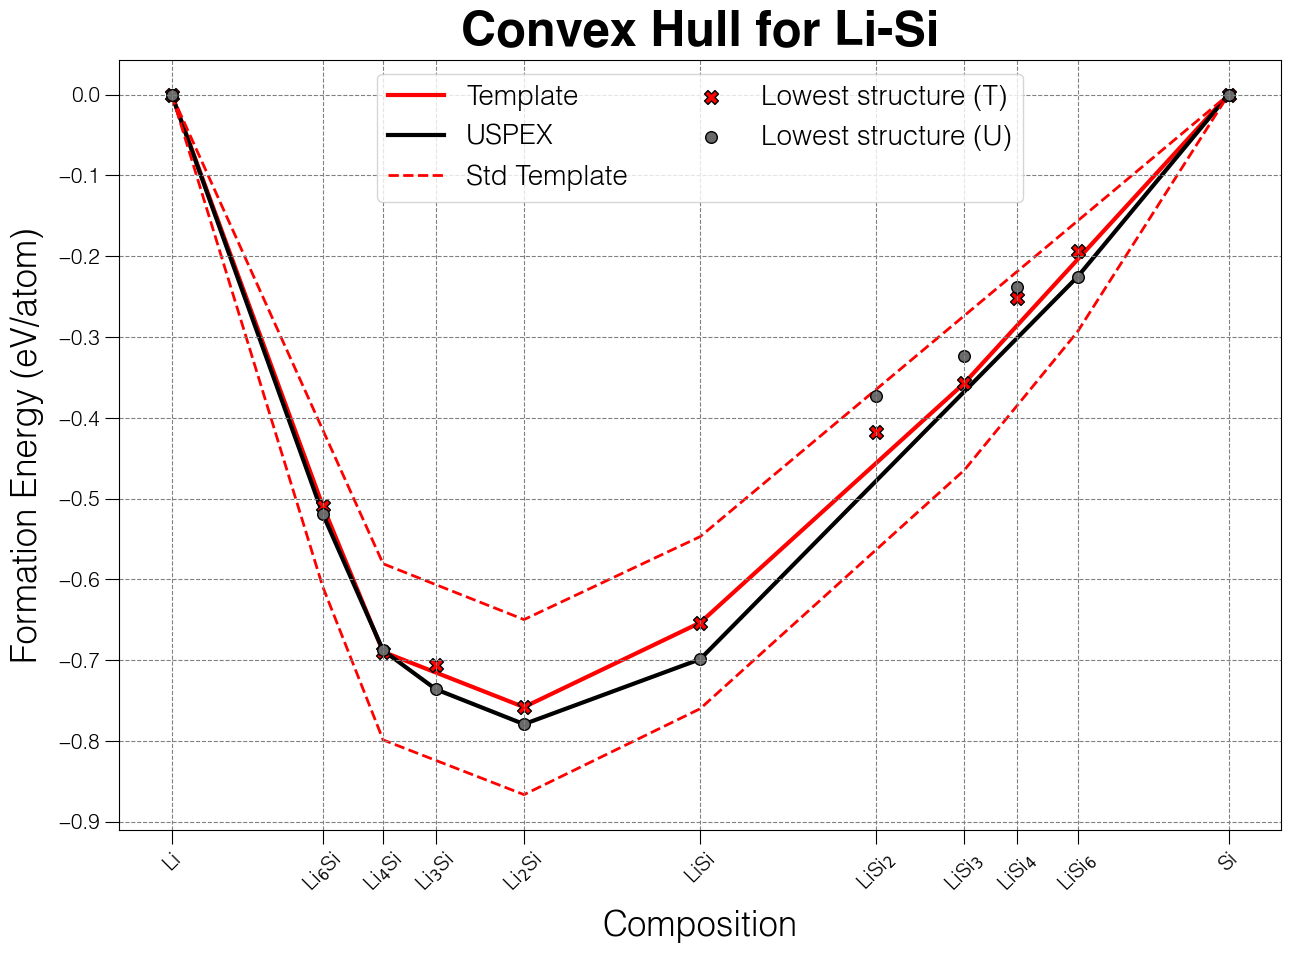

In [ ]:
import matplotlib.pyplot as plt
import re
import json
from pyfonts import load_font
from matplotlib.font_manager import FontProperties

# load font
helvetica_bold = load_font("/home/seraf/Downloads/helvetica-255/Helvetica-Bold.ttf")
helv_bold_prop = FontProperties(fname="/home/seraf/Downloads/helvetica-255/Helvetica-Bold.ttf", size=35)

helvetica_regular = load_font("/home/seraf/Downloads/helvetica-255/Helvetica.ttf")
helvetica_strange = load_font("/home/seraf/Downloads/helvetica-255/helvetica-light-587ebe5a59211.ttf")

helv_strange_prop = FontProperties(fname="/home/seraf/Downloads/helvetica-255/helvetica-light-587ebe5a59211.ttf", size=20)

dir_dati = './DATA_DICT/'

with open(dir_dati + 'InfoHullTemp.json') as f:
    info_hull = json.load(f)

with open(dir_dati + 'InfoHullStd.json') as f:
    info_std_hull = json.load(f)

with open(dir_dati + 'MinimumEachComp/PhaseDiagramUspex.json', 'r') as f:
    phase_diagram_uspex = json.load(f)

with open(dir_dati + 'MinimumEachComp/PhaseDiagramTemp.json', 'r') as f:
    phase_diagram_temp = json.load(f)


pair = 'LiSi'
A = re.findall(r'[A-Z][a-z]?', pair)[0]
B = re.findall(r'[A-Z][a-z]?', pair)[1]
x = [1/7,1/5,1/4,1/3,1/2,2/3,3/4,4/5,6/7]


x_temp = info_hull[pair]['temp_hulls_x']
y_temp = info_hull[pair]['temp_hulls_y']

x_gs = info_hull[pair]['uspex_hulls_x']
y_gs = info_hull[pair]['uspex_hulls_y']

x_std_max = info_std_hull[pair]['upper_limit_x']
y_std_max = info_std_hull[pair]['upper_limit_y']

x_std_min = info_std_hull[pair]['lower_limit_x']
y_std_min = info_std_hull[pair]['lower_limit_y']

values_temp = phase_diagram_temp[pair]
values_temp.append(0)
values_temp.insert(0,0)
values_gs = phase_diagram_uspex[pair]
values_gs.append(0)
values_gs.insert(0,0)
x = [0,1/7,1/5,1/4,1/3,1/2,2/3,3/4,4/5,6/7,1]


fig, ax = plt.subplots(1,1, figsize=(15,10))
ax.set_title(f'Convex Hull for {A}-{B}', fontproperties=helv_bold_prop, pad=10)

ax.plot(x_temp, y_temp, color='red', zorder=1, lw = 3, label='Template')
ax.plot(x_gs, y_gs, color='black', zorder=1, lw = 3, label='USPEX')
ax.plot(x_std_max, y_std_max, color='red', ls ='--', zorder=1, lw = 2, label='Std Template')
ax.plot(x_std_min, y_std_min, color='red', ls ='--', zorder=1, lw = 2)

ax.scatter(x, values_temp, color='red', s=100, marker='X', edgecolors='black', label='Lowest structure (T)')
ax.scatter(x, values_gs, color='dimgrey', s=70, marker='o', edgecolor='black', label='Lowest structure (U)')

ax.set_xticks(x)
ax.set_xticklabels([A, f'{A}$_6${B}', f'{A}$_4${B}', f'{A}$_3${B}', f'{A}$_2${B}', f'{A}{B}', f'{A}{B}$_2$', f'{A}{B}$_3$', f'{A}{B}$_4$', f'{A}{B}$_6$', B], rotation=45)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(helvetica_strange)

ax.tick_params(size=10, labelsize=15)
ax.set_xlabel('Composition', fontsize=25, font=helvetica_strange, labelpad=10)
ax.set_ylabel('Formation Energy (eV/atom)', fontsize=25, font=helvetica_strange, labelpad=10)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

ax.grid( linestyle='--', color='gray')
ax.legend(loc= 'upper center', prop=helv_strange_prop, ncol=2)
# fig.savefig(f'./FIG/Articolo/ConveHullEx_sometemp.png', dpi=300, bbox_inches='tight')

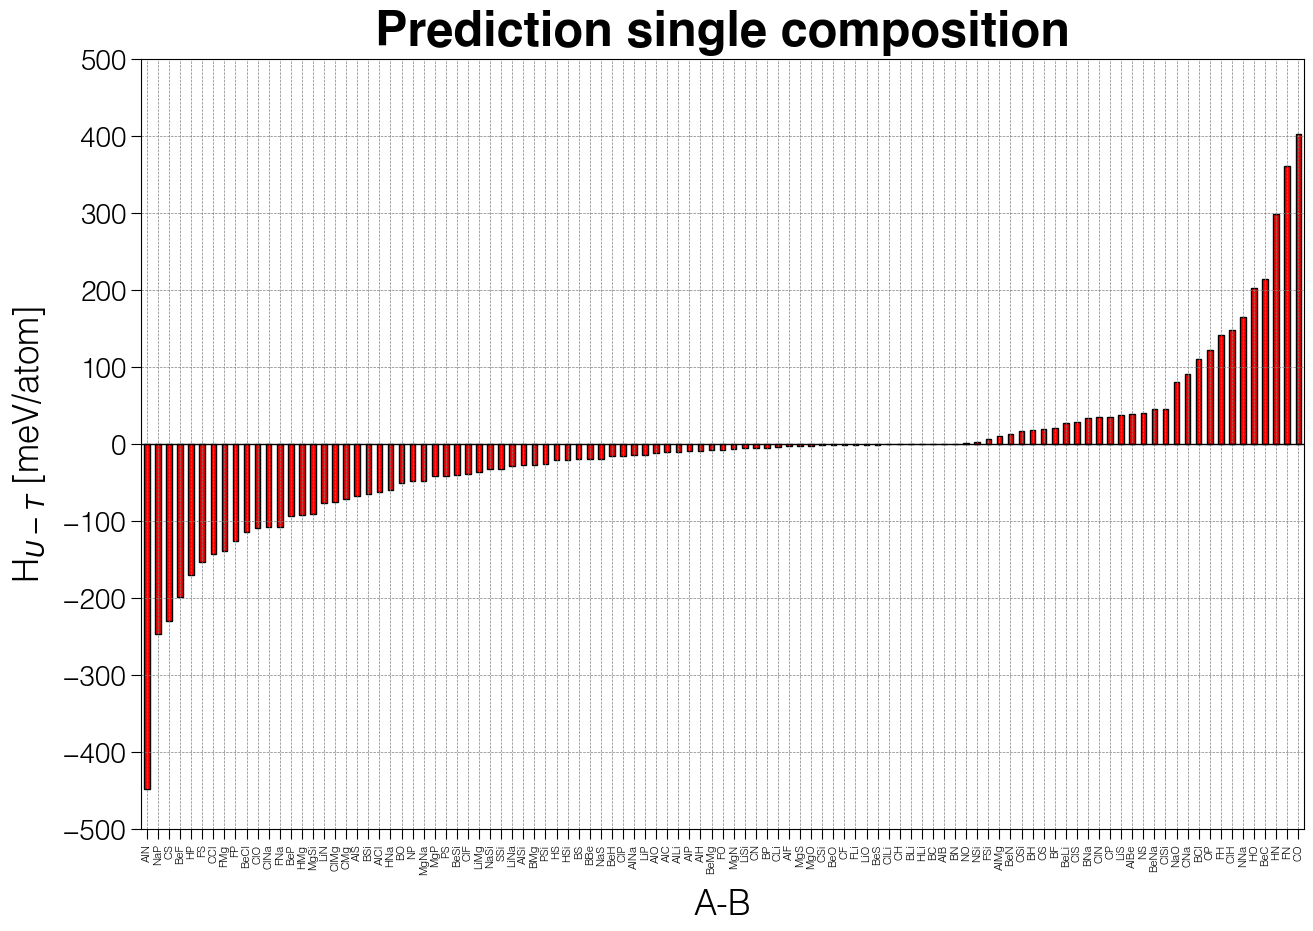

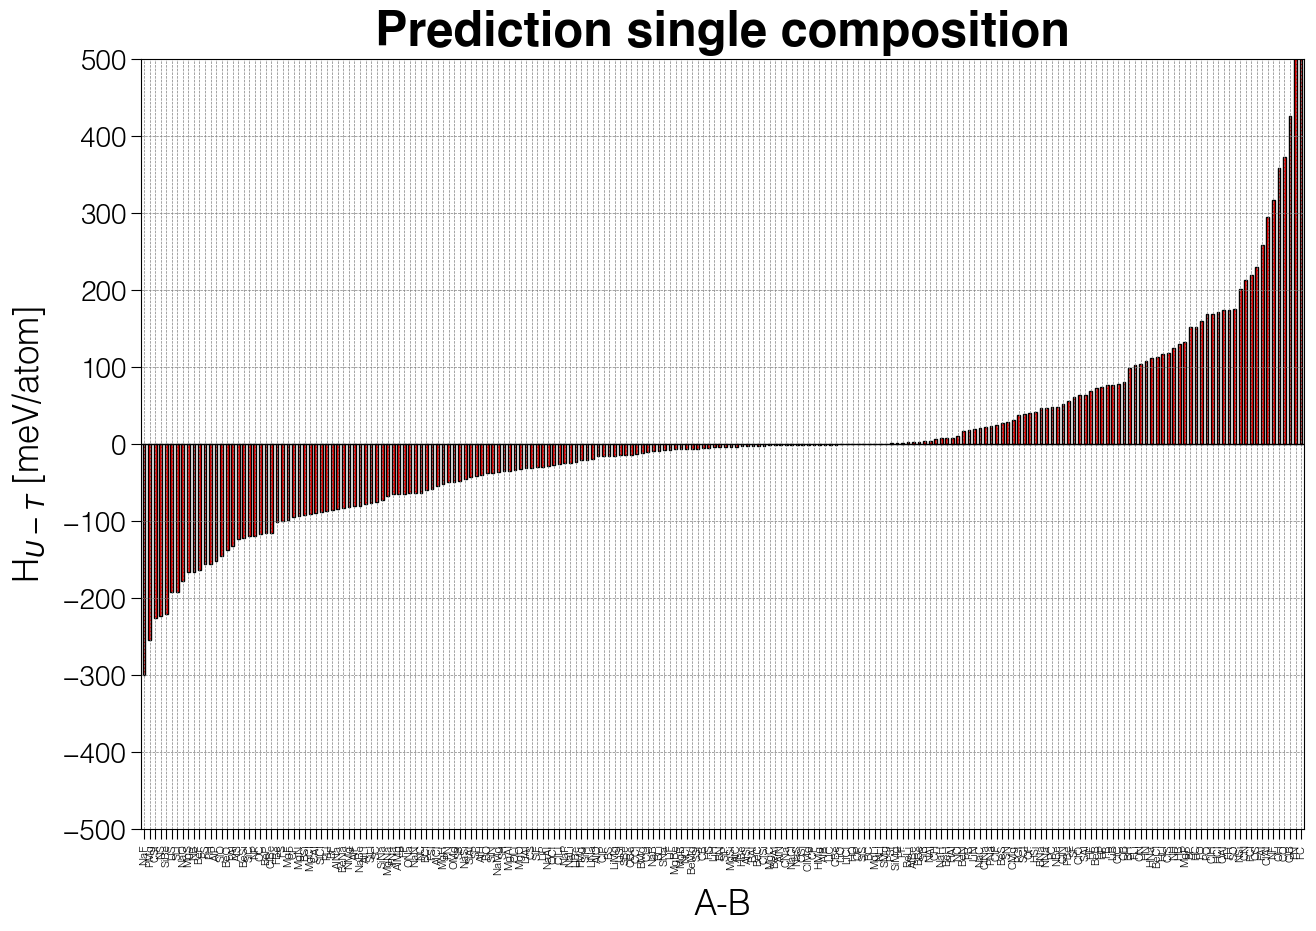

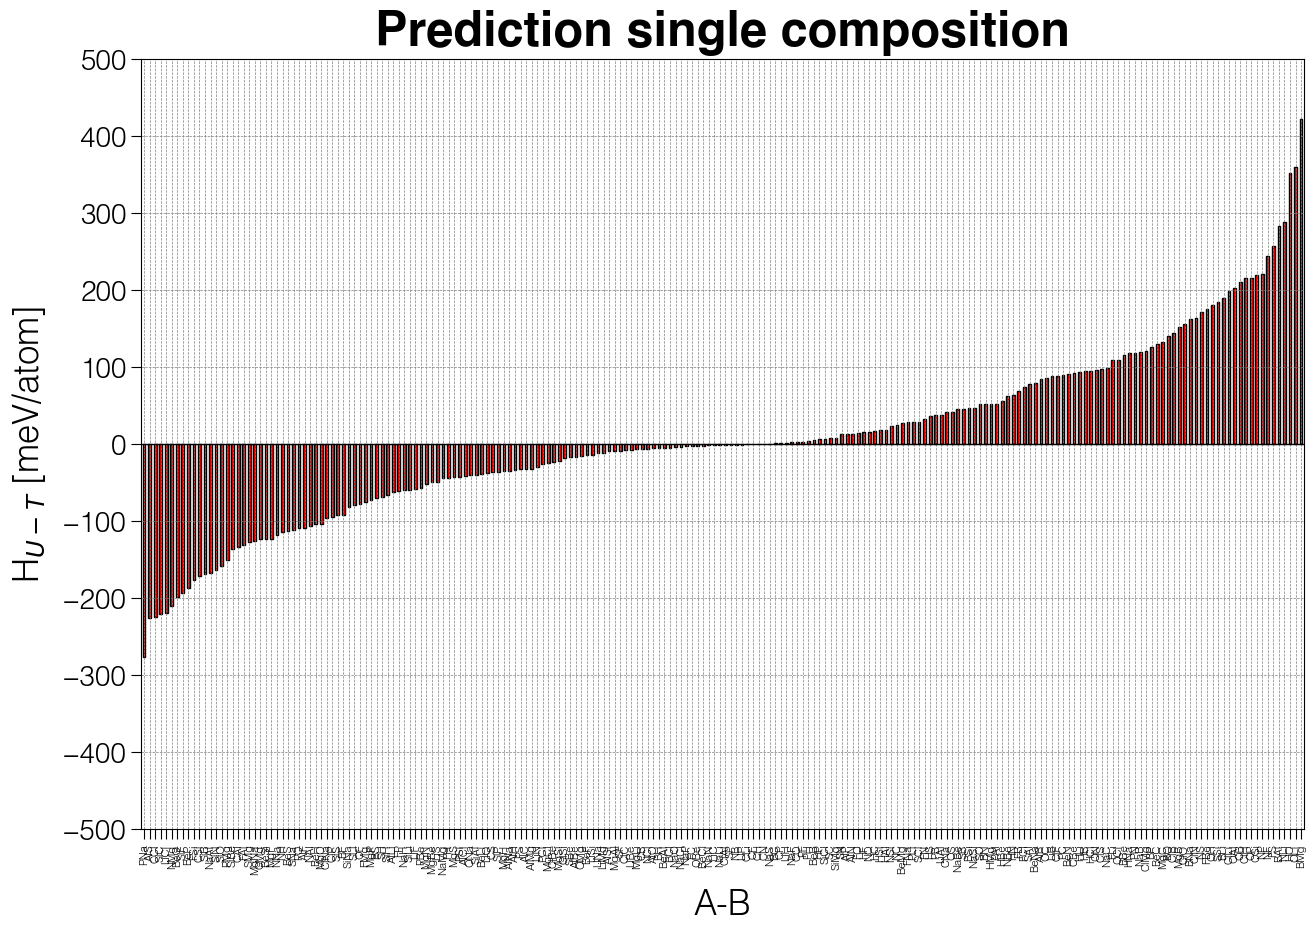

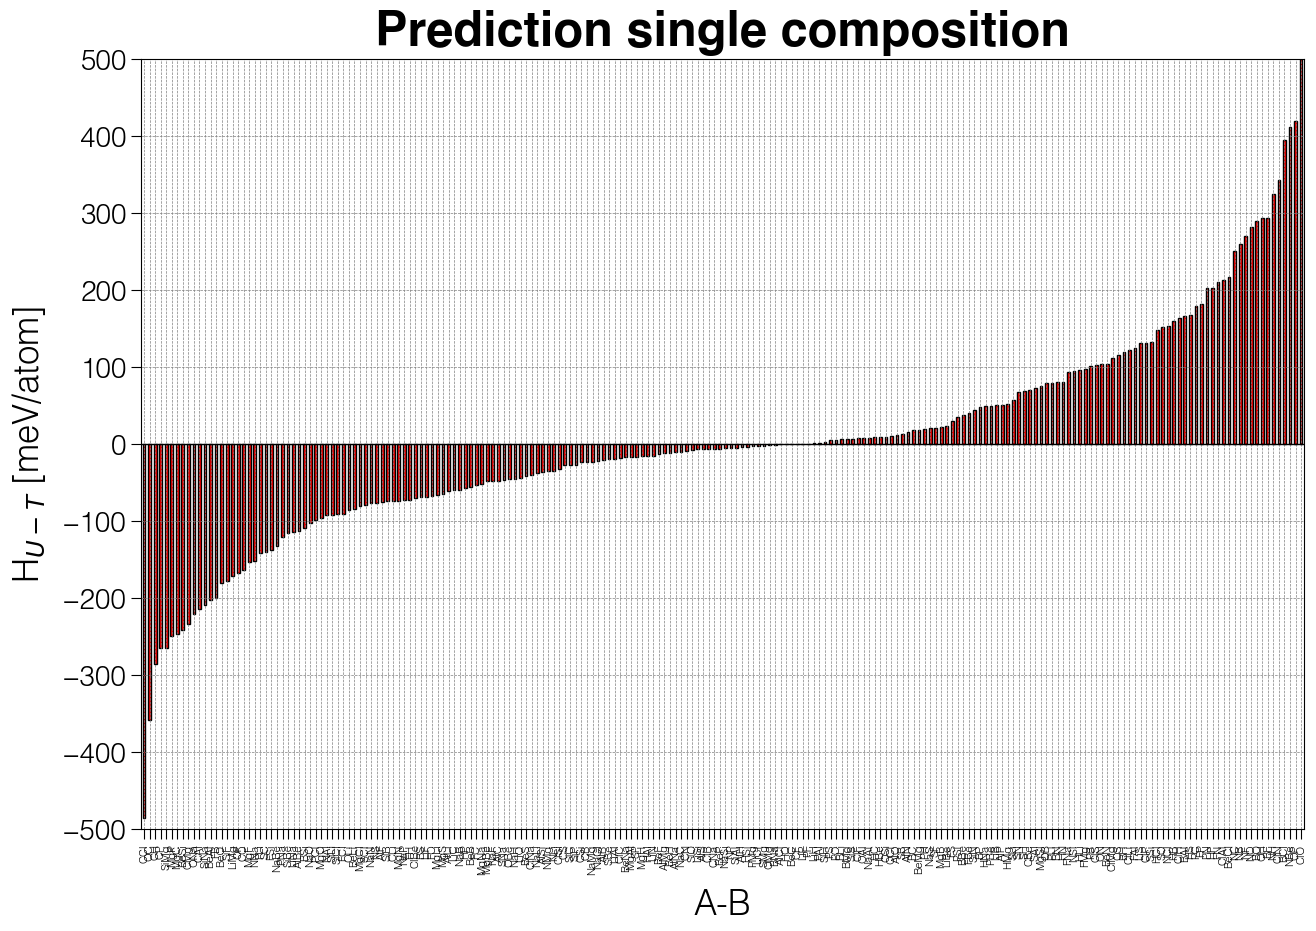

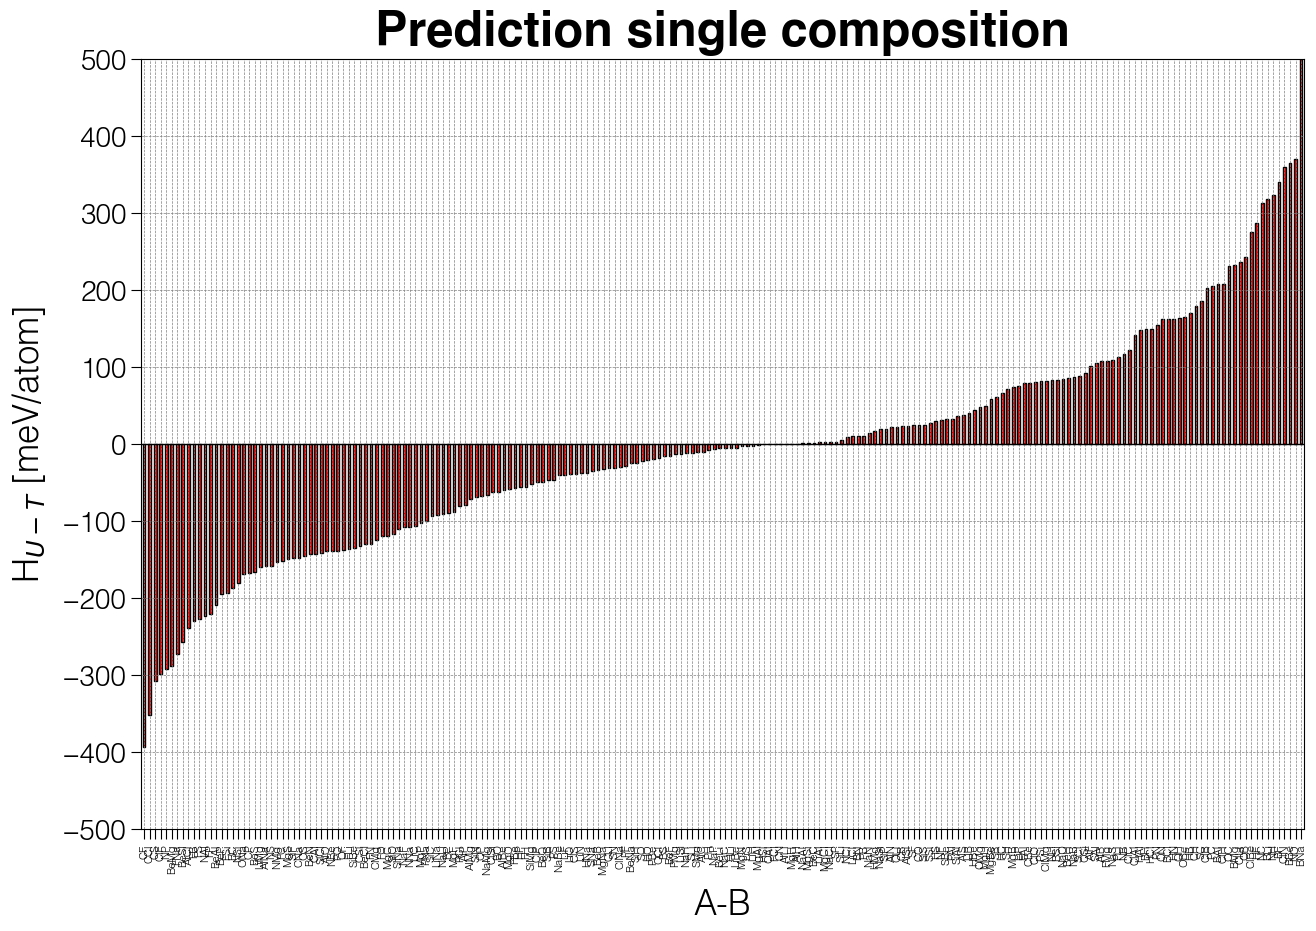

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import json

from pyfonts import load_font
from matplotlib.font_manager import FontProperties

# load font
helvetica_bold = load_font("/home/seraf/Downloads/helvetica-255/Helvetica-Bold.ttf")
helv_bold_prop = FontProperties(fname="/home/seraf/Downloads/helvetica-255/Helvetica-Bold.ttf", size=35)

helvetica_strange = load_font("/home/seraf/Downloads/helvetica-255/helvetica-light-587ebe5a59211.ttf")
helv_strange_prop = FontProperties(fname="/home/seraf/Downloads/helvetica-255/helvetica-light-587ebe5a59211.ttf", size=8)
helv_strange_prop_big = FontProperties(fname="/home/seraf/Downloads/helvetica-255/helvetica-light-587ebe5a59211.ttf", size=20)

complist = [1,2,3,4,6]

for comp in complist:
    with open(f'./ENTHALPY/A{comp}B.json', 'r') as f:
        data_temp = json.load(f)
    with open('ENTHALPY/EntGS.json', 'r') as f:
        data_gs = json.load(f)

    temp_to_use = [x for x in data_temp['BBe'].keys()]

    some_temp = False
    if some_temp:
        with open('DATA_DICT/TempExtractedExRun.json', 'r') as f:
            dict_temp = json.load(f)
        temp_to_use = dict_temp[f'{comp}']


    x = []
    y = []
    for pair in data_temp.keys():
        ent_temps = []
        for temp in temp_to_use:
            ent_temps.append(data_temp[pair][temp])

        ent_gs = data_gs[f'{comp}'][pair]
        y.append(min(ent_temps) - ent_gs)
        x.append(pair)

    x = np.array(x)
    y = np.array(y)
    idx_sorted = np.argsort(y)
    x = x[idx_sorted]
    y = y[idx_sorted] 

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    title = f'Prediction single composition'
    ax.set_title(title, fontproperties=helv_bold_prop, pad=10)

    ax.set_xlabel('A-B', fontsize=25, font=helvetica_strange, labelpad=10)
    xticks = np.arange(0,  len(x), 1)

    ax.set_xticks(xticks)
    ax.set_xlim(-0.5, len(x)-0.5)    
    ax.set_xticklabels([f'{x[i]}' for i in xticks], rotation=90)

    ax.set_ylabel(r'H$_{U-T}$ [meV/atom]', fontsize=25, font=helvetica_strange, labelpad=10)
    ax.tick_params(size=7)
    for label in ax.get_xticklabels():
        label.set_fontproperties(helv_strange_prop)

    ax.set_ylim(-500, 500)
    ax.yaxis.set_major_locator(plt.MultipleLocator(100))

    for label in ax.get_yticklabels():
        label.set_fontproperties(helv_strange_prop_big)

    ax.bar(xticks, np.array(y)*1000, color='red', edgecolor='black', width=0.5)

    ax.grid( linestyle='--', color='gray', lw=0.5)
    ax.axhline(0, color='black', lw=1)
    fig.savefig(f'./FIG/Articolo/SINGLECOMP_{comp}_alltemp.png', dpi=300, bbox_inches='tight')
